# MPC Additional Resources: Forecasting

This page presents different methodologies for prediction of returns that can be used by the MeanVariance MPC.

In order to keep the [introduction to the MeanVariance MPC framework](https://github.com/JuDO-dev/AirBorne.jl/blob/dev/docs/example_notebooks/MPC_Example.ipynb) short, the introduction to forecasting models has been presented here. 

1. Last Value
2. Linear Regression
3. Behavioural Forecast
4. Hidden Markov Model

In [159]:
# Setup the dependencies
using Pkg; Pkg.add("Suppressor"); using Suppressor: @suppress;
@suppress Pkg.add(url="https://github.com/JuDO-dev/AirBorne.jl#dev");
@suppress Pkg.add(["Dates","Plots","DataFrames", "DirectSearch","DotMaps","LinearAlgebra","Polynomials","SparseArrays","MathOptInterface","HiddenMarkovModels","Distributions"]);

## DataSet
This dataset is formed by the top 5 most traded companies according to NASDAQ in each sector as per 3rd August 2023, listed since 2016 from Jan 1st 2017 until Jan 1st 2022.

In [160]:
using DataFrames: groupby, combine
########################################################
###    Pick the 5 most traded companies per sector   ###
########################################################
using AirBorne.ETL.NASDAQ: screener
using AirBorne.Utils: get_latest_N
tickers_df = screener()
filtered_df =tickers_df[[   x!="" ? parse(Int64, x)<2016 : false for x in tickers_df.ipoyear],["symbol","marketCap","sector","volume"]]
filtered_df[!,"volume"]=parse.(Int64,filtered_df[!,"volume"])
filtered_df[!,"marketCap"]=parse.(Float64,filtered_df[!,"marketCap"])
grouped_df = groupby(filtered_df,"sector")
f(sdf)= get_latest_N(sdf,:volume,5;rev=true)
result = combine(grouped_df,f)

#####################################################
###    Extract interday date from Yahoo Finance   ###
#####################################################
using AirBorne.ETL.Cache: store_bundle
bundle_id="Mark1"
cache_dir = joinpath(@__DIR__, "data", "cache")
# To generate the "demo" data use:
using AirBorne.ETL.YFinance: get_interday_data
using AirBorne.ETL.Cache: store_bundle
using Dates: DateTime, datetime2unix
from = DateTime("2017-01-01"); to = DateTime("2022-01-01")
u_from = string(round(Int, datetime2unix(from)));
u_to = string(round(Int, datetime2unix(to)))
data = get_interday_data(result.symbol, u_from, u_to)
store_bundle(data; bundle_id=bundle_id, archive=true, cache_dir=cache_dir)
@info "Done!"
first(data,4)

In [161]:
# If you already have the data somewhere accessible by the cache loading the data directly is faster
using AirBorne.ETL.Cache: load_bundle
bundle_id="Mark1"
cache_dir = joinpath(@__DIR__, "data", "cache")
data=load_bundle(bundle_id;cache_dir=cache_dir)
using AirBorne.ETL.AssetValuation: stockValuation, returns
dollar_symbol = "FEX/USD"
account_currency = dollar_symbol
sv=stockValuation(data)
sv[!,dollar_symbol].=1.0
sr=returns(sv)
@info "DataGenerated"

## Methods

### Perfect forecast

We refer to **Perfect Forecasting** to the return of the actual data. If there is a method that were capable of predicting exactly the evolution of the return it would be called the perfect forecast. 

In this forecast the variance is considered to be 0, as the knowledge of the precise behaviour of the return is known in advance, a perfect forecast does not have a sense of volatility on its predictions. An empirical sense of covariance can be drawn ex post the prediction but does not a emerge from a probabilistic nature of the forecast itself. 



In [173]:
using AirBorne.Structures: ContextTypeA  # Define context
using DataFrames: DataFrame
# First Look Among dynamic hyper-parameters, then look into static hyper-parameters
c_get(context,key,default) = get(context.parameters,key, get(context.extra,key, default))

function perfectForecastReturns(context::ContextTypeA,returnData::DataFrame)
    n_assets = length(context.extra.symbolOrder)
    horizon = c_get(context,"futureHorizon",7) 
    r_mat=float.(Matrix(first(sr[sr.date.>context.current_event.date,context.extra.symbolOrder],horizon)))
    Σ = zeros(n_assets,n_assets)
    return [ (r_mat[i,:],Σ) for i=1:horizon] # Mean-Variance Forecast 
end

perfectForecastReturns (generic function with 1 method)

In [174]:
using AirBorne.Structures: ContextTypeA, TimeEvent # Define context
import AirBorne.Strategies.MeanVarianceMPC as MPC

pf_context = ContextTypeA(TimeEvent(DateTime("2020-01-01"),"start"))

pf_params = Dict(
    "futureHorizon"=>7,
)
pf_extras = Dict(
    "symbolOrder"=>["NYQ/SPR", "NMS/TSLA", "NMS/AMZN"],
)
MPC.initialize!(pf_context;currency_symbol=account_currency,min_data_samples=20,otherExtras=pf_extras,parameters=pf_params)
# Note: Once initialized context.symbolOrder looks like: ["NYQ/SPR", "NMS/TSLA", "NMS/AMZN", account_currency] 

perfectForecastFun(context) = perfectForecastReturns(context,sr)
perfectForecastFun(pf_context)

7-element Vector{Tuple{Vector{Float64}, Matrix{Float64}}}:
 ([0.01948416371919179, 0.028518175015711245, 0.027150610354876845, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])
 ([-0.004037725968178341, 0.029633258297920753, -0.012139034655920934, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])
 ([-0.0025676005595439188, 0.019254637045135074, 0.014885573930506536, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])
 ([0.015851589717382656, 0.03880052465815389, 0.0020916204156393933, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])
 ([-0.013603684006325336, 0.04920482578812169, -0.007808640261289332, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])
 ([-0.015819337255656412, -0.021945011900097317, 0.004799174786468337, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])
 ([-0.042450940079958234, -0.0066272976331742195, -0.009410596802


### Last Value
The last value forecast assumes that in the future the value doesn't change, therefore whatever was the last return will also be in the future.

This approach is the one used by the Markowitz Strategy were the investement is done by measuring the expected return over a certain number days in the past and one assumes that in the future the expected return and the covariance between the returns of the asset will remain approximately the same. 


In [164]:


function LV_Forecast(context::ContextTypeA)
    # Hyper-Parameters
    varianceWindowSize  = c_get(context, "varianceWindowSize", 7)
    expectedReturnWindowSize  = c_get(context, "expectedReturnWindowSize", 7)
    pastHorizon = c_get(context,"pastHorizon", 7)
    futureHorizon = c_get(context,"futureHorizon", 5)
    
    minDataPoints =  max(expectedReturnWindowSize,varianceWindowSize)+1
    if size(context.extra.returnHistory,1) < minDataPoints
        error("Not enough data, please allow $(minDataPoints) data events before forecasting. Current datapoints: $(size(context.extra.returnHistory,1))")
    end
    
    # On an update this can be made more efficient by only calculating the latest value
    rMat = float.(Matrix(context.extra.returnHistory[end-minDataPoints+1:end,context.extra.symbolOrder])) # Initial Returns Matrix    
    # Memory Pre-allocation
    μ = mean(rMat[end-expectedReturnWindowSize+1:end,:];dims=1)
    if varianceWindowSize>1
        Σ = cov(rMat[end-varianceWindowSize+1:end,:])
    else
        Σ = zeros(size(rMat,2),size(rMat,2))
    end
    return [(μ,Σ) for i=1:futureHorizon] 
end

LV_Forecast (generic function with 1 method)

In [165]:
using AirBorne.Structures: ContextTypeA, TimeEvent # Define context
import AirBorne.Strategies.MeanVarianceMPC as MPC
lv_context = ContextTypeA(TimeEvent(DateTime("2020-01-01"),"start"))

lv_params = Dict(
    "futureHorizon"=>1,
    "varianceWindowSize"=>20, # Number of datapoints to use to calculated expected (use 0 to not estimate variance)
    "expectedReturnWindowSize"=>20, # Number of datapoints to estimate expected returns (use 1 to use the last value and not an expectation)
)
lv_extras = Dict(
    "symbolOrder"=>["NYQ/SPR", "NMS/TSLA", "NMS/AMZN"],
)

MPC.initialize!(lv_context;currency_symbol=account_currency,min_data_samples=20,otherExtras=lv_extras,parameters=lv_params)
lv_context.extra.returnHistory = first(sr,21) # Data to be fed at first (for test purposes)

LV_Forecast(lv_context) 

1-element Vector{Tuple{Matrix{Float64}, Matrix{Float64}}}:
 ([-0.0023538027780066724 0.007062436275320651 0.005027746495853143 0.0], [0.0004995679646997508 0.00015384383078589437 1.3403134695204724e-5 0.0; 0.00015384383078589437 0.00023584721564700925 5.778185962852423e-6 0.0; 1.3403134695204724e-5 5.778185962852423e-6 0.00010736210280677346 0.0; 0.0 0.0 0.0 0.0])


### Linear regression

**Linear Regression** fits a line through a number of past datapoints, the linear regression can be applied to:
1. The return vector as a whole (or each element of the return vector separately)
1. Each element of the covariance matrix


In [166]:
using AirBorne.ETL.AssetValuation: covariance
using Statistics: cov,mean
using JuMP: @variable, @expression, Model, @objective, @constraint, optimize!, @NLobjective, value, set_silent
using Ipopt: Ipopt

function LR_Forecast(context::ContextTypeA)
    # Hyper-Parameters
    elementWise = c_get(context,"elementWise",true)
    varianceWindowSize  = c_get(context, "varianceWindowSize", 7)
    expectedReturnWindowSize  = c_get(context, "expectedReturnWindowSize", 7)
    pastHorizon = c_get(context,"pastHorizon", 7)
    futureHorizon = c_get(context,"futureHorizon", 5)
    
    minDataPoints =  pastHorizon+max(expectedReturnWindowSize,varianceWindowSize)
    if size(context.extra.returnHistory,1) < minDataPoints
        error("Not enough data, please allow $(minDataPoints) data events before forecasting. Current datapoints: $(size(context.extra.returnHistory,1))")
    end
    
    rMat = float.(Matrix(context.extra.returnHistory[end-minDataPoints+1:end,context.extra.symbolOrder])) # Initial Returns Matrix    
    # Memory Pre-allocation
    μMat = zeros(futureHorizon,size(rMat,2))
    ΣMat = zeros(size(rMat,2),size(rMat,2),futureHorizon)
    for i= size(rMat,1)-pastHorizon+1:size(rMat,1) 
        ix= i-(size(rMat,1)-pastHorizon) 
      μMat[ix,:] = mean(rMat[i-expectedReturnWindowSize+1:i,:];dims=1)
      ΣMat[:,:,ix] = cov(rMat[i-varianceWindowSize+1:i,:])
    end
    
    # Pre-allocate Forecast Matrices
    μFMat = zeros(futureHorizon,size(rMat,2))
    ΣFMat = zeros(size(rMat,2),size(rMat,2),futureHorizon)

    if elementWise # Forecast each entry of μ & Σ using normal linear regression
        aμ= zeros(size(μMat[1,:]))
        bμ= zeros(size(μMat[1,:]))
        aΣ= zeros(size(ΣMat[:,:,1]))
        bΣ= zeros(size(ΣMat[:,:,1]))
        X = hcat(ones(pastHorizon,1), 1:pastHorizon)
        XX=((X'*X)^-1)
        for i=1:length(aμ)
            bμ[i],aμ[i] = XX * (X' * μMat[:,i])
            for j=1:i # Leverage Symmetry
               bΣ[j,i],aΣ[j,i] = bΣ[i,j],aΣ[i,j] =  XX * (X' * ΣMat[i,j,:])
            end
        end
    else # Forecast μ & Σ as points of a high dimensional space
        μmodel = Model(Ipopt.Optimizer)
        μShape=size(μMat[1,:])[1]
        @variable(μmodel, a[1:μShape[1]])
        @variable(μmodel, b[1:μShape[1]])
        @objective(μmodel,Min,sum([sum(x.^2) for x in [a*i+b-μMat[i,:] for i=1:pastHorizon]]))
        optimize!(μmodel)
        aμ = deepcopy(value.(a)) 
        bμ = deepcopy(value.(b)) 
        Σmodel = Model(Ipopt.Optimizer)
        ΣShape=size(ΣMat[:,:,1])
        @variable(Σmodel, a[1:ΣShape[1],1:ΣShape[2]]) 
        @variable(Σmodel, b[1:ΣShape[1],1:ΣShape[2]])# I could add constraint of symmetry & diagonal being strictly positive
        @objective(Σmodel,Min,sum([sum(x.^2) for x in [a*i+b-ΣMat[:,:,i] for i=1:pastHorizon]]))
        optimize!(Σmodel)
        aΣ = deepcopy(value.(a)) 
        bΣ = deepcopy(value.(b)) 
    end

    μf(i) = aμ.*i + bμ
    Σf(i) = aΣ.*i + bΣ
    out=[]
    for i = 1:futureHorizon
        μFMat[i,:] = μf(i+pastHorizon)'
        ΣFMat[:,:,i] = Σf(i+pastHorizon)
        push!(out,(μFMat[i,:],ΣFMat[:,:,i]))
    end
   return out 
end



LR_Forecast (generic function with 1 method)

In [167]:
using AirBorne.Structures: ContextTypeA, TimeEvent # Define context
import AirBorne.Strategies.MeanVarianceMPC as MPC
using Dates:DateTime

lr_context = ContextTypeA(TimeEvent(DateTime("2020-01-01"),"start"))

lr_params = Dict(
    "futureHorizon"=>7, # How many future predictions to make
    "pastHorizon"=>7, # How many past samples to take
    "varianceWindowSize"=>7, # Spread of the covariance moving average measurement
    "expectedReturnWindowSize"=>1, # Spread of the covariance moving average measurement
)

lr_extras = Dict(
    "symbolOrder"=> ["NYQ/SPR", "NMS/TSLA", "NMS/AMZN"]
)

MPC.initialize!(lr_context;currency_symbol=account_currency,min_data_samples=20,otherExtras=lr_extras,parameters=lr_params)
lr_context.extra.returnHistory = first(sr,14) # Data to be fed at first (for test purposes)

LR_Forecast(lr_context)

7-element Vector{Any}:
 ([0.009566263825567887, 0.014744185136356995, 0.0006894765029014944, 0.0], [0.0006180203437277521 0.0002818905296865593 4.6540077681892547e-5 0.0; 0.0002818905296865593 0.00022485396907219912 4.68220737516061e-5 0.0; 4.6540077681892547e-5 4.68220737516061e-5 4.8178511657771394e-5 0.0; 0.0 0.0 0.0 0.0])
 ([0.01305519410831451, 0.015524491285541588, 1.8235459586122757e-5, 0.0], [0.0006857077493204667 0.0003151808870165336 5.034906097339285e-5 0.0; 0.0003151808870165336 0.00022007781274946815 5.683730035539976e-5 0.0; 5.034906097339285e-5 5.683730035539976e-5 3.5374253397799695e-5 0.0; 0.0 0.0 0.0 0.0])
 ([0.016544124391061135, 0.01630479743472618, -0.0006530055837292497, 0.0], [0.0007533951549131813 0.0003484712443465079 5.415804426489315e-5 0.0; 0.0003484712443465079 0.00021530165642673718 6.685252695919343e-5 0.0; 5.415804426489315e-5 6.685252695919343e-5 2.2569995137827997e-5 0.0; 0.0 0.0 0.0 0.0])
 ([0.020033054673807754, 0.017085103583910775, -0.0013242466270

### Behavioural method

#### Single index trajectory forecast
Single index trajectories are the simplest to analyse and we shall use this section to introduce the **Behavioural model** for **Linear Time Invariant** (LTI) systems.

Recently a result from Behavioural systems known as the "fundamental lemma" implied that any trajectory of a LTI system can be described by a linear combination of previous trajectories of the same system.

Let's explain the above statement through an example. Let's say we have the value of a LTI system we want to predict, on time 1 it takes the value *h1*, at time 2 the value *h2* and so on. 

Now suppose that we define trajectories made by 3 consecutive values of this process and we want to predict the 3rd value of the current trajectory using the 2 last values. Moreover let us use the following definitions:

1. First trajectory from data **\[ *h1*, *h2*, *h3* ]**
1. Second trajectory from data **\[  *h2*, *h3*, *h4* ]**
1. Current trajecotry so far:  **\[  *h3*, *h4*, ? ]** 

With this information we can define what we call the **Hankel** matrix **H** shown below.

$$
H = \begin{bmatrix} 
    h_1 & h_2\\ 
    h_2 & h_3 \\ \hdashline 
    h_3 & h_4 \end{bmatrix} 
$$

Along with submatrices known as the *past Hankel* matrix Hp and the *future Hankel* matrix Hf.

$$H_p=\begin{bmatrix} h_1 & h_2\\h_2 & h_3 \end{bmatrix} $$
$$H_f\begin{bmatrix} h_3 & h_4 \end{bmatrix} $$

Then the problem becomes finding the coefficients of a linear combination **g** that matches our current data and using it to predict the next ones: 

$$
H_p*g=\begin{bmatrix} 
    h_1 & h_2\\ 
    h_2 & h_3 \end{bmatrix} * g = \begin{bmatrix}
    h_3\\ h_4 \end{bmatrix} 
$$

$$
g=H_p^{-1}\begin{bmatrix} h_3 \\ h_4 \end{bmatrix} 
$$
$$
\hat{h}_5=H_f*g = \begin{bmatrix} h_3 & h_4 \end{bmatrix}  *g
$$

#### Multi index trajectory forecast
So far the trajectory prediction relies on forming an invertible matrix for to match the past values and then taking the weights on the future values to make the forecast. 


##### Option 1: Forecasting asset values separately
This requires the same amount of historical data, however there is no clear connection between the covariancce of the future trajectories. Lets examine Apple for example where the value of its shares is at time **i** is represented by **ai** 

$$
H = \begin{bmatrix}
    a_1 & a_2\\
    a_2 & a_3 \\  
    a_3 & a_4 \end{bmatrix} 
$$
$$
H_p*g=\begin{bmatrix} a_1 & a_2\\ a_2 & a_3 \end{bmatrix} * g = \begin{bmatrix} a_4 \\ a_5 \end{bmatrix} 
$$

$$
g=H_p^{-1}\begin{bmatrix} a_4 \\ a_5 \end{bmatrix} 
$$
$$
\hat{a}_5=H_f*g = \begin{bmatrix} a_3 & a_4 \end{bmatrix}  *g
$$

##### Option 2: Forecast asset value together
If one does it together on the other hand the amount of time samples to look into the past grows  significantly. Observe that the hankel matrix from stacking on top of each other A and B are is now of size 3*2 this means that the number of rows we will obtain is equal to  the full-horizon length times the number of assets being forecasted together.

$$
H_{1,2} = \begin{bmatrix} 
            a_1 & a_2\\
            a_2 & a_3\\
            a_3 & a_4\\
            b_1 & b_2\\
            b_2 & b_3\\
            b_3 & b_4\\ 
            \end{bmatrix} 
$$

Shuffling the rows around we cluster the past and future rows together by doing something like below. Where we can observe that the number of columns needed to obtain a past invertible matrix is equal to past-horizon times the number of assets forecasted together. 

> **Curse of dimensionality** Considering that there are more than 3000 assets retrievable by NASDAQ alone, just trying to forecast the next day by using 2 days in the past having full cross-correlation coverage implies having to use more than 10 years of past data, moreover consider that assets that were once correlated now may not be and assets now correlated may not have been before and not all assets existed 10 years ago, the problem becomes absurd from a contextual  point of view.

**Then the problem becomes:**
$$
H_{1,2} = \begin{bmatrix} 
            a_1 & a_2 & a_3 & a_4 \\
            b_1 & b_2 & b_3 & b_4 \\
            a_2 & a_3 & a_4 & a_5 \\
            b_2 & b_3 & b_4 & b_5 \\\hdashline 
            a_3 & a_4 & a_5 & a_6 \\ 
            b_3 & b_4 & b_5 & b_6 \\ 
            \end{bmatrix} 
$$

$$
H_p*g=\begin{bmatrix} 
            a_1 & a_2 & a_3 & a_4 \\
            b_1 & b_2 & b_3 & b_4 \\
            a_2 & a_3 & a_4 & a_5 \\
            b_2 & b_3 & b_4 & b_5 \\\end{bmatrix} * g = \begin{bmatrix} 
a_5 \\
b_5 \\
a_6 \\
b_6 \\ \end{bmatrix} 
$$

$$
\begin{bmatrix} \hat{a}_7 \\ \hat{b}_7 \end{bmatrix}=H_f*g = \begin{bmatrix}a_3 & a_4 & a_5 & a_6 \\ b_3 & b_4 & b_5 & b_6 \\  \end{bmatrix}  * g
$$

With this definition one can calculate the covariance of the trajectories using the traditional formula of the covariance.


In [168]:
using AirBorne.Structures: ContextTypeA

function quickBehaviouralForecast(Y,y_ini)
   return  Y[length(y_ini)+1:end,:] * (Y[1:length(y_ini),:]\y_ini)
end

function behaviouralForecast(context::ContextTypeA)
    
    ########################
    ### Hyper-Parameters ###
    ########################
    elementWise = c_get(context,"elementWise",true)
    pastHorizon = c_get(context,"pastHorizon", 7)
    futureHorizon = c_get(context,"futureHorizon", 5)
    varianceWindowSize  = get(context.parameters, "varianceWindowSize", 0)
    expectedReturnWindowSize  = get(context.parameters, "expectedReturnWindowSize", 1)
    
    # The minimum data points in case of elementwise forecast is equal to the past horizon (I may exclude the currency as its value is always 1, thus its returns and variance always 0)
    trajetory_length = (pastHorizon + futureHorizon) * (elementWise ? 1 : length(context.extra.symbolOrder)-1)
    n_columns_for_reversibility = (pastHorizon) * (elementWise ? 1 : length(context.extra.symbolOrder)-1)
    N = trajetory_length + n_columns_for_reversibility # Number of datapoints in Hankel Matrix
    
    minDataPoints =  trajetory_length + n_columns_for_reversibility +  max(expectedReturnWindowSize,varianceWindowSize) # @info "minDataPoints" minDataPoints
    if size(context.extra.returnHistory,1) < minDataPoints
        error("Not enough data, please allow $(minDataPoints) data events before forecasting. Current datapoints: $(size(context.extra.returnHistory,1))")
    end

    ###############################
    ### Statistics Calculations ###
    ###############################
    
    # TODO: Implement incremental updates to Hankel Matrix to improve efficiency
    rMat = float.(Matrix(context.extra.returnHistory[end-minDataPoints+1:end,context.extra.symbolOrder])) # Initial Returns Matrix
    if c_get(context,"excludeCurrencyFromCalculation", true)
        rMat = rMat[:,1:end-1] # Remove last column
    end
    
    μMat = zeros(N,size(rMat,2))
    ΣMat = zeros(size(rMat,2),size(rMat,2),N)
    for i= size(rMat,1)-N+1:size(rMat,1) 
        # @info i
        ix= i-(size(rMat,1)-N) 
        # @info ix
      μMat[ix,:] = expectedReturnWindowSize > 1 ? mean(rMat[i-expectedReturnWindowSize+1:i,:];dims=1) : rMat[i,:]
      if  varianceWindowSize > 1; ΣMat[:,:,ix] = cov(rMat[i-varianceWindowSize+1:i,:]); end
    end
    
    ###############################
    ### Behavioural Forecasting ###
    ###############################
    
    # Memory pre-allocation
    μFMat = zeros(futureHorizon,size(rMat,2)+1) # Forecast of expected return
    ΣFMat = zeros(size(rMat,2)+1,size(rMat,2)+1,futureHorizon) # Forecast of variance
    if elementWise
        # TODO: If happy with results do not store all the matrices, just re-write them to reduce memory allocation
        # The key on updating hankel matrices is to keep track of the oldest column and replace it with the new trajectory
        # The number of columns is n_columns_for_reversibility. So a counter with a modulus operator should suffice
        # There are extra nuances when considering the span of the trajectories.
        
        # Memory pre-allocation
        HΣi = zeros(trajetory_length,n_columns_for_reversibility) # Individual Covariance Hankel Matrix for asset pair
        Hμ = zeros(trajetory_length,n_columns_for_reversibility, size(rMat,2)) # Hankel Matrices for expected returns
        HΣ = Dict() # Hankel Matrices for covariance (since there is a lot of symmetry in this matrix, a hashmap is chosen as storage structure)
        
        μ_ini = μMat[end-pastHorizon+1:end,:] # Initial condition for expected returns
        Σ_ini = zeros(size(rMat,2),size(rMat,2),pastHorizon)
        
        for assetIx=1:size(rMat,2) # Iterate over each column (each asset)
            Hμ[:,:,assetIx]= cat([ μMat[end-i-trajetory_length+1:end-i] for i=1:n_columns_for_reversibility]...;dims=2)
            μFMat[:,assetIx]= quickBehaviouralForecast(Hμ[:,:,assetIx],μ_ini[:,assetIx])
            if varianceWindowSize>1 # Only go here if necessary
                for coAssetIx=1:assetIx # Build Hankel Matrix for Covariance
                    Σ_ini[assetIx,coAssetIx,:] = Σ_ini[coAssetIx,assetIx,:] = ΣMat[assetIx, coAssetIx, end-pastHorizon+1:end] 
                    HΣi[:,:] = cat([ ΣMat[assetIx, coAssetIx, end-i-trajetory_length+1:end-i]  for i=1:n_columns_for_reversibility]...;dims=2)
                    HΣ[(coAssetIx,assetIx)] = HΣ[(assetIx,coAssetIx)] = HΣi
                    ΣFMat[coAssetIx,assetIx,:] = ΣFMat[assetIx,coAssetIx,:] = quickBehaviouralForecast(HΣi,ΣMat[assetIx, coAssetIx, end-pastHorizon+1:end] )
                end
            end
         end
    else # Apply Behavioural forecast to all asset together, we need chunks 
        nAssets=size(rMat,2)
        μVec = reshape(μMat',1,:) # Restructured into: [a1,b1,c1,a2,b2,c2,...,aN,bN,cN] # Reshape μMat into 1D vector, easier to manipulate # @info "μMat" μMat μVec
        μ_ini = μVec[end-pastHorizon*nAssets+1:end]
        Hμ= cat(reverse([μVec[end-trajetory_length-nAssets*(i-1)+1:end-nAssets*(i-1)] for i=1:n_columns_for_reversibility])...;dims=2) # @info "Hμ" μ_ini Hμ 
        μF =  quickBehaviouralForecast(Hμ,μ_ini )
        μFMat[:,1:end-1] = vcat([μF[1+nAssets*(i-1):nAssets*i]' for i=1:futureHorizon]...)# @info "μF" μF μFMat
        
        # Comments on Covariance Forecasting
        # Trying to do the same thing with the covariance matrix makes the amount of data to grow quadratically with respect
        # to the number of symbols traded. (This is because the array will look like aa1,ab1,ac1,bb1,bc1,cc1,aa2,...,aaN,abN,...,ccN]
        # This is not practical unless for a small number of investment choices, therefore the Variance forecast will be set to 0
        # And the correlation between trajectories will be assumed to be assessed on the compound μ trajectory
        
    end
    return [(μFMat[i,:],ΣFMat[:,:,i]) for i=1:futureHorizon]
end

behaviouralForecast (generic function with 1 method)

In [169]:
using AirBorne.Structures: ContextTypeA, TimeEvent # Define context
import AirBorne.Strategies.MeanVarianceMPC as MPC
b_context = ContextTypeA(TimeEvent(DateTime("2020-01-01"),"start"))

b_params = Dict(
    "futureHorizon"=>5,
    "pastHorizon"=>4,
    
    "varianceWindowSize"=>3,
    "expectedReturnWindowSize"=>5,
    
    "elementWise"=>false, 
)
b_extras = Dict(
    "symbolOrder"=>["NYQ/SPR", "NMS/TSLA", "NMS/AMZN"],
)

MPC.initialize!(b_context;currency_symbol=account_currency,min_data_samples=20,otherExtras=b_extras,parameters=b_params)
b_context.extra.returnHistory = first(sr,100) # Data to be fed at first (for test purposes)

BehaviouralForecast(b_context) 

┌ Info: minDataPoints
└   minDataPoints = 44


5-element Vector{Tuple{Vector{Float64}, Matrix{Float64}}}:
 ([-0.021485554689682707, -0.0032748777555403072, 0.01856092581889145, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])
 ([0.01844158385200624, -0.05818649387016962, 0.0013020575161824502, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])
 ([-0.024052265317587647, -0.04089345751425147, 0.002011901434353737, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])
 ([-0.0009373376224481242, -0.03562122921606613, 0.025559807823324416, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])
 ([0.037452482441856984, 0.04189054112935138, 0.03174360647594799, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])

### Hidden Markov Model (HMM) with MultiVariate Gaussian State

In this example the **HMM** models the behaviour of the returns in discrete states which are not directly observable, each state is represented as a time-invariant stochastic process were at each time-instant its distribution follows a MultiVariate Gaussian distribution with fix mean vector and covariance matrix.

Given past data, the **Baum-Welch** method is used to estimate the transition probability between these hidden states and the coefficients of the MultiVariate Gaussians associated to each hidden state.

Using recent past data the current state is estimated, and the forecast of covariance and mean vectors is computed in an iterative manner.

**A huge advantage of this method** is that if the coefficients of the HMM are not modified significantly the forecast matrices will only depend on the current state, and it can be precomputed and save in memory.

> Note: At the moment the *HiddenMarkovModels* package in Julia just estimates the most likely state, and it doesn't provide the most likely probility distribution of states, which could be used for a refinement of the forecasted vectors and matrices. 

In [266]:
using HiddenMarkovModels: HMM, transition_matrix, baum_welch, viterbi, obs_distribution, rand_trans_mat #, em
using Distributions: MvNormal
using LinearAlgebra: I

#######################
### Handy functions ###
#######################
function random_gaussian_hmm(N,dims)
       state_probability = ones(N) / N  # initial distribution (of the states)
       state_transition_matrix = rand_trans_mat(N)  # transition matrix (of the states)
       state_Covariance = Matrix(I, dims, dims).*1.0
       dists = [MvNormal(rand(dims),  state_Covariance) for n in 1:N]  # observation distributions (of the states)
       return HMM(state_probability, state_transition_matrix, dists)
end

function fitHMM(hmm_init,obs_seq)
    hmm_est, logL_evolution = baum_welch(hmm_init, obs_seq; rtol=-Inf, check_loglikelihood_increasing=false)
   return hmm_est
end

function gen_hmm(obs_seq::Vector{Vector{Float64}}; nHiddenStates::Int64=2, hmm_init::Union{Nothing,HMM}=nothing)
       if isnothing(hmm_init)
           hmm_init=random_gaussian_hmm(nHiddenStates,length(obs_seq[1]))
       end
         @info "fitHMM"
       return fitHMM(hmm_init,obs_seq)
end

matrix2seq(obs_seq) = [obs_seq[i,:] for i=1:size(obs_seq,1)]
get_current_state(hmm,obs_seq) = viterbi(hmm, obs_seq)[end]

######################
### HMM Forecaster ###
######################
using AirBorne.Structures: ContextTypeA

function hmmForecast(context::ContextTypeA)
    excludeCurrencyFromCalculation = c_get(context, "excludeCurrencyFromCalculation", true)
    futureHorizon = c_get(context,"futureHorizon",7)
    # If new data has come update observation sequence
    if  size(context.extra.returnHistory,1)>context.extra.lastScanIx
        # Remove Currency Symbol (as they are all 0)
        symbols =  excludeCurrencyFromCalculation ? context.extra.symbolOrder[1:end-1] : context.extra.symbolOrder
        new_obs_seq = matrix2seq(float.(Matrix(
                    context.extra.returnHistory[context.extra.lastScanIx:end,symbols]
        )))
        if length(context.extra.obs_seq)==0
            context.extra.obs_seq=Vector{Vector{Float64}}(new_obs_seq)
        else
            append!(context.extra.obs_seq,new_obs_seq)
        end
        context.extra.lastScanIx = size(context.extra.returnHistory,1)
    end  
    if  (mod(context.extra.lastScanIx, context.parameters.recalibrationPeriod)==0) || isnothing(context.extra.hmm)
        context.extra.hmm = gen_hmm(context.extra.obs_seq; hmm_init=context.extra.hmm)
    end
    hmm = context.extra.hmm; N=length(hmm);
    fitDists=[obs_distribution(hmm,i) for i=1:length(hmm)]
    μs= [f.μ for f=fitDists];    Σs=[f.Σ for f=fitDists]
    q0 = zeros(N);
    q0[get_current_state(hmm,context.extra.obs_seq)] = 1 # Probability of each state at t=0
    μ0 = sum(q0.*μs); Σ0 = sum([ q0[i].*Σs[i] for i=1:N])
    M=length(μ0)
    oM= length(context.extra.symbolOrder)
    
    # Pre-allocation of output
    forecast = [(zeros(oM),zeros(oM,oM)) for i=1:futureHorizon] 
    for i=1:futureHorizon
        q1 = transition_matrix(hmm)*q0
        μ1 = sum(q1.*μs)
        Σ1 = sum([ q1[i].*(Σs[i] + ((μs[i]-μ1)*(μs[i]-μ1)'))  for i=1:N]) 
        q0,μ0,Σ0=q1,μ1,Σ1
        forecast[i][1][1:M]=μ1
        forecast[i][2][1:M,1:M]=Σ1
    end
    return forecast
end


hmmForecast (generic function with 2 methods)

In [171]:
using AirBorne.Structures: ContextTypeA, TimeEvent # Define context
using Dates: DateTime

#############
### Usage ###
#############
traded_assets = ["NYQ/SPR", "NMS/TSLA", "NMS/AMZN"]
obs_seq = matrix2seq(float.(Matrix(sr[!,traded_assets])))
hmm = gen_hmm(obs_seq)

HMM_context = ContextTypeA(TimeEvent(DateTime("2020-01-01"),"start"))

pf_params = Dict(
    "futureHorizon"=>7,
    "recalibrationPeriod"=>50, # Index to keep track of not yet ingested data.
)
pf_extras = Dict(
    "hmm"=>hmm, # Initial Hidden Markov Model
    "obs_seq"=>obs_seq, # Initial Warm-Start Data 
    "symbolOrder"=>traded_assets,
    "lastScanIx"=>0, # Index to keep track of not yet ingested data.
)

account_currency = "FEX/USD"
MPC.initialize!(
            HMM_context;
            currency_symbol=account_currency,
            min_data_samples=0,
            otherExtras=pf_extras,
            parameters=pf_params,
        )
hmmForecast(HMM_context)

7-element Vector{Any}:
 ([0.000706250722467759, 0.0026554241313998103, 0.0016905311662124757], [0.0008216140824952495 0.00020383680397072148 6.0076108272199236e-5; 0.00020383680397072148 0.0011012365397966464 0.0001895404647804474; 6.0076108272199236e-5 0.0001895404647804474 0.0002678920271649398])
 ([0.0005627965714500093, 0.003434970999984343, 0.0016491487991550794], [0.0012730910359189508 0.0003020474033952231 7.961698677559675e-5; 0.0003020474033952231 0.0014939867844180387 0.000263886044266459; 7.961698677559675e-5 0.000263886044266459 0.00035750384773232223])
 ([0.0004587815157887248, 0.00400020114739477, 0.0016191434686551748], [0.001600410156279743 0.00037337309527509573 9.375742740784518e-5; 0.00037337309527509573 0.001778556412321934 0.00031792271674521206; 9.375742740784518e-5 0.00031792271674521206 0.00042246587754560353])
 ([0.0003833627723960608, 0.004410035542755398, 0.0015973873458804727], [0.0018377244523604596 0.0004251392776621728 0.00010399609175745467; 0.0004251392

## Benchmarking
Now we shall compare the performance of each method by running a simulation over time of them using the AirBorne DEDS simulation engine with a customized trading logic method that solely performs the forecasting on each simulation event.

In [452]:
using AirBorne.Structures: ContextTypeA, TimeEvent
import AirBorne.Strategies.MeanVarianceMPC as MPC

using Dates: year

# 2017/18 - Warm Up data
# 2019+ - Comparison

# The data goes from 2017 to 2022, we could use the returns of 2017 to warmstart the return history and the events 
# on +2018 to run the simulation

warmpUpYear=2018
hyperParameterTrainYears=1
returnHistoryWarmUp = sr[year.(sr.date).<=warmpUpYear,:]
simulationEvents = [TimeEvent(t, "data_transfer") for t in sort(unique(data.date); rev=true) if ( (t>=DateTime(warmpUpYear+1,1,1)) && (t<DateTime(warmpUpYear+1+hyperParameterTrainYears,1,1)))]

traded_assets=["NYQ/SPR", "NMS/TSLA", "NMS/AMZN"]
account_currency = "FEX/USD"

params = Dict(
    "pastHorizon"=>7, # All (-Perfect)
    "varianceWindowSize"=>3, # All (-HMM)
    "expectedReturnWindowSize"=>5,# All (-HMM)
    "recalibrationPeriod"=>50, # HMM: Index to keep track of not yet ingested data.
    "elementWise"=>true, # Behavioural, Linear Regression
)

extras = Dict( 
    
    "futureHorizon"=>7, # All
    "symbolOrder"=>traded_assets, # All
    
    # HMM Exclusive
    "hmm"=>nothing, # Initial Hidden Markov Model
    "obs_seq"=>[], # Initial Warm-Start Data
    "lastScanIx"=>1, # Index to keep track of not yet ingested data.
    
    "excludeCurrencyFromCalculation"=>true, # Behavioural & HMM: Reduce dimensionality of problem by 1
    
    "forcastFunctions"=>Dict(
        "Perfect"=> perfectForecastFun,
        "LastValue"=> LV_Forecast,
        "LinearRegression"=> LR_Forecast,
        "Behavioural"=>behaviouralForecast,
        "HMM"=>hmmForecast,
        ), 
    
    "forecastResults"=>[], 
)

account_currency = "FEX/USD"


function my_initialize!(context) 
    MPC.initialize!(
            context;
            currency_symbol=account_currency,
            min_data_samples=0,
            otherExtras=extras,
            parameters=params,
        )
    context.extra.returnHistory = returnHistoryWarmUp # Data to be fed at first (for warm-start purposes)
end

function forcastTradingLogic!(context, data)
    #######################
    ####  Update data  ####
    #######################
    if size(data, 1) == 0 # No New data, nothing to do
        return nothing
    end
    context.extra.pastValue = context.extra.currentValue

    context.extra.currentValue = stockValuation(data)
    context.extra.currentValue[!, context.extra.currency_symbol] .= 1.0 # Add currency to values

    [push!(context.extra.valueHistory, r) for r in eachrow(context.extra.currentValue)]

    if size(context.extra.pastValue, 1) > 0 # Add new data to history record
        r1 = returns(vcat(context.extra.pastValue, context.extra.currentValue))
        push!(context.extra.returnHistory, r1[end, :])
    end

    ###############
    ####  MPC  ####
    ###############

    if size(context.extra.returnHistory, 1) < context.extra.min_data_samples
        return nothing # Not enough history data to continue
    end
    context.extra.forecastResults= Dict([ id=>fun(context) for (id, fun) in context.extra.forcastFunctions])
end

using AirBorne.Engines.DEDS: run
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data

my_expose_data(context, data) = expose_data(context, data; historical=false)

function my_execute_orders!(context, data)
    return execute_orders!(context, data; propagateBalanceToPortfolio=true)
end

context = run(
        data,
        my_initialize!,
        forcastTradingLogic!,
        my_execute_orders!,
        my_expose_data;
        verbose=true,
        audit=true,
        max_iter=90,
        initialEvents=simulationEvents,
    )
@info "Done"

[ Info: fitHMM
[ Info: fitHMM
[ Info: Done


### Analysis: Mean Squared Error of **μ** 

Here the error of each forecast is evaluated in terms of its expected return **μ** against the actual return of each asset. Variance calculations are not considered in this first analysis. 

Let
$$\mu_i^{o}:\text{True value of the forecasted returns at time i (composed of returns at time i+1,i+2,...,i+forcastHorizon)}$$
$$\mu_i^{o} \text{ is a matrix with one row per asset and one column per day into the future forecasted.}$$

$$\mu_i^{\alpha}:\text{Forecast of expected returns at time i using the method }\alpha$$
$$\delta_i^{\alpha}:\text{ Difference between the forecast of the expected returns and actual returns at time i using the method }\alpha$$
$$ M^{\odot (2)}:\text{ Elementwise squared operation on each entry of a tensor M}$$
$$ \mu{}{Error}^\alpha: \text{Squared error tensor of method }\alpha \text{ after simulation}$$


$$
(\delta_i^{\alpha})^{\odot (2)} = (\mu_i^{o}-\mu_i^{\alpha})^{\odot (2)}
$$

$$
\mu{}{Error}^\alpha = [ \delta_1^\alpha, \delta_2^\alpha, ..., \delta_N^\alpha]^{\odot (2)}
$$

The first figure to observe is the average accuracy of each method with respect to how deep into the future the forecast is, as the average errors of each method can be magnitudes apart, the figures are usually shown in logarithmic scale.



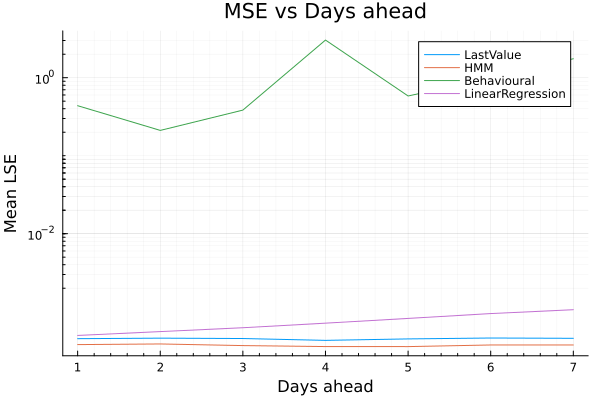

In [449]:
# Start Analysis from 3rd day first two events do not produce a forecast, throw them away. (1st one is captured pre-initialization and 2nd Post initialization)
refkey = :Perfect
f = context.audit.extraHistory[3].forecastResults
refs = keys(context.extra.forcastFunctions)

# μFcastMat[asset,daysAheadforecast,forecastEvent] expected return forecasted 
μFcastMat = zeros(length(context.extra.symbolOrder),context.extra.futureHorizon, length(context.audit.extraHistory)-2)
μFcast = Dict([ref=>deepcopy(μFcastMat) for ref=refs]) # Pre-allocation
for simEvent=3:length(context.audit.extraHistory), ref=refs
    μFcast[ref][:,:,simEvent-2] = vcat([x[1] for x=context.audit.extraHistory[simEvent].forecastResults[ref]]...)'
end
μError = Dict([ref=>(μFcast[ref]-μFcast[refkey]).^2 for ref=refs]) #Squared error on each entry

using Plots: plot,plot!
plotRefs=[ref for ref=refs if ref!=refkey]
plot(1:context.extra.futureHorizon,[reshape(mean(μError[ref];dims=(1,3)),1,:)' for ref=plotRefs],label=reshape(string.(plotRefs),1,:),title="MSE vs Days ahead", xlabel="Days ahead", ylabel="MSE", yscale=:log10, minorgrid=true)


### Analysis: Adjusted MSE 

Here the error of each forecast is evaluated in terms of how far from the expected deviation has the forecast landed. To do this we divide the absolute value of the squared error over the magnitude of the variance along the direction of the error. 

This method cannot be applied to measure the accuracy against individual assets but instead it focuses in the overall accuracy of the return vector against the variance in the direction of the error.

$$
\delta_{\Sigma i} = sum \left((\delta_i^{\alpha})^{\odot (2)}\right) \times \frac{\delta_i' \Sigma_i^\alpha \delta_i}{\delta_i'\delta_i}: \text{}
$$

The main idea in this approach is to penalize large variances (variances with large eigenvalues).


[ Info: LastValue complies for further analysis
[ Info: HMM complies for further analysis
[ Info: Behavioural has some values NaN which indicates that Σ may not be positive definite
[ Info: Perfect is the reference and thus omitted
[ Info: LinearRegression has some values NaN which indicates that Σ may not be positive definite


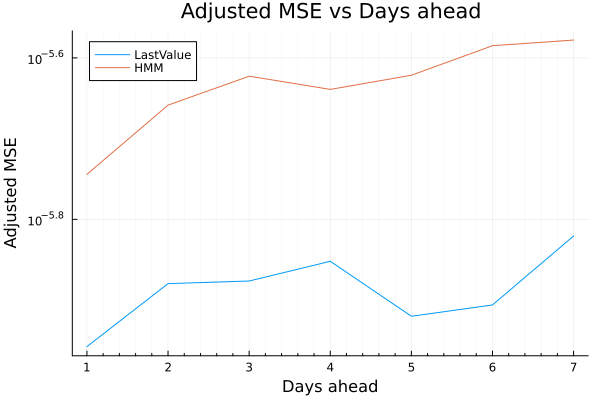

In [451]:
using Plots: plot,scatter, xlabel!, ylabel!, title!
"Scales the error against the variance in the direction of the error"
function μΣErrorFun(δ,Σ)
    if iszero(Σ); return NaN; end
    if iszero(δ); return 0; end
    out = sum(δ.^2)*(float(δ*Σ*δ')[1])/((δ*δ')[1]) # Covariance is not always positive definite (which is problematic!)
    return out > 0 ? out : NaN
end

# μΣErrorMat[daysAheadforecast,forecastEvent] 
μΣErrorMat = zeros(context.extra.futureHorizon, length(context.audit.extraHistory)-2)
μΣErrorDict = Dict([ref=>deepcopy(μΣErrorMat) for ref=refs]) # Pre-allocation

𝛿Mat = Dict([ref=>μFcast[ref]-μFcast[refkey] for ref=refs]) # [ref] [asset,daysAheadforecast,forecastEvent] 
M=4
for simEvent=3:length(context.audit.extraHistory), ref=refs
    𝛿s = 𝛿Mat[ref][:,:,simEvent-2] 
    Σs = [x[2] for x=context.audit.extraHistory[simEvent].forecastResults[ref]]
    μΣErrorDict[ref][:,simEvent-2] = [μΣErrorFun(reshape(𝛿s[:,i],1,:),reshape(Σs[i],M,M)) for i=1:context.extra.futureHorizon]'
end

plotRefs=[ref for ref=refs if (ref!=refkey) && !(any(isnan.(μΣErrorDict[ref])))]
for ref=refs
   if ref==refkey
        @info "$(ref) is the reference and thus omitted"
   elseif all(isnan.(μΣErrorDict[ref])) # TODO: Put better test for this
        @info "$(ref) has all values NaN which indicates that Σ is always 0"
   elseif any(isnan.(μΣErrorDict[ref])) # TODO: Put better test for this
        @info "$(ref) has some values NaN which indicates that Σ may not be positive definite"
   else
       @info "$(ref) complies for further analysis" 
    end
end
plot(1:context.extra.futureHorizon, [reshape(mean(float.(μΣErrorDict[ref]);dims=(2)),1,:)' for ref=plotRefs], label=reshape(string.(plotRefs),1,:), yscale=:log10, minorgrid=true)
xlabel!("Days ahead")
ylabel!("Adjusted MSE")
title!("Adjusted MSE vs Days ahead")

It can be observed that even in this minimal example, many of the attempted methods fail to produce a covariance matrix that is positive definite. 

In particular the methods that are element wise, the **Linear Regression** and **Behavioural** methods, this implies that exist a vector such that the total variance becomes negative. This is foreseeable as each element of the covariance matrix is forecasted independently from the rest. In order to avoid this pitfall one could predict the covariance matrix in a high dimensional space, the **Linear Regression does not suffer the curse of dimensionality** however the **Behavioural method does**.   

### Discussion on results

From this particular example HMM seems to have overall better predictive results than their other approaches, whilst the behavioural method has significantly worse performance in this implementation. Is worth noticing that this implementation of the behavioural method is not refined and further corrections and enhancements to it have been put forward in academic research, therefore no final conclusion on this method (or any of the methods) is attempted to be drawn here as this is just a singular experiment with the objective of illustrating how to produce forecasting techniques for the **Mean Variance MPC Strategy**.

Having said that is worth testing that the covariance matrices produced "**Σ**" to be positive definite as if they are not incoherent results may be provided, if in doubt is advisable to just let the covariance matrices be 0 (to exclude them from the cost function).
